In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, \
    LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

In [2]:
DATA_DIR = '/Users/dima/Projects/free-spoken-digit-dataset/recordings/'

In [55]:
random_file = rn.choice(os.listdir(DATA_DIR))

In [56]:
wav, sr = librosa.load(DATA_DIR + random_file)
print 'sr:', sr
print 'wav shape:', wav.shape
print 'length:', wav.shape[0]/float(sr), 'secs'

sr: 22050
wav shape: (10849,)
length: 0.49201814059 secs


In [5]:
wav, sr = librosa.load(DATA_DIR + random_file, sr=None)
print 'sr:', sr
print 'wav shape:', wav.shape
print 'length:', wav.shape[0]/float(sr), 'secs'

sr: 8000
wav shape: (1700,)
length: 0.2125 secs


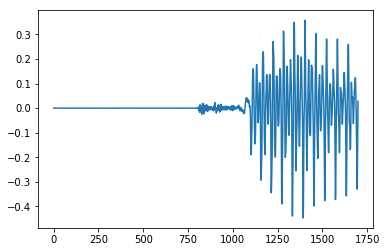

In [6]:
plt.plot(wav)

In [7]:
test_speaker = 'theo'
train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

for fname in os.listdir(DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        struct = fname.split('_')
        digit = struct[0]
        speaker = struct[1]
        wav, sr = librosa.load(DATA_DIR + fname)
        padded_x = pad1d(wav, 30000)
        spectrogram = np.abs(librosa.stft(wav))
        padded_spectogram = pad2d(spectrogram,40)

        mel_spectrogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = pad2d(mel_spectrogram,40)

        mfcc = librosa.feature.mfcc(wav)
        padded_mfcc = pad2d(mfcc,40)

        if speaker == test_speaker:
            test_X.append(padded_x)
            test_spectrograms.append(padded_spectogram)
            test_mel_spectrograms.append(padded_mel_spectrogram)
            test_mfccs.append(padded_mfcc)
            test_y.append(digit)
        else:
            train_X.append(padded_x)
            train_spectrograms.append(padded_spectogram)
            train_mel_spectrograms.append(padded_mel_spectrogram)
            train_mfccs.append(padded_mfcc)
            train_y.append(digit)
    except Exception as e:
        print fname, e
        raise

train_X = np.vstack(train_X)
train_spectrograms = np.array(train_spectrograms)
train_mel_spectrograms = np.array(train_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_X = np.vstack(test_X)
test_spectrograms = np.array(test_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))


print 'train_X:', train_X.shape
print 'train_spectrograms:', train_spectrograms.shape
print 'train_mel_spectrograms:', train_mel_spectrograms.shape
print 'train_mfccs:', train_mfccs.shape
print 'train_y:', train_y.shape
print
print 'test_X:', test_X.shape
print 'test_spectrograms:', test_spectrograms.shape
print 'test_mel_spectrograms:', test_mel_spectrograms.shape
print 'test_mfccs:', test_mfccs.shape
print 'test_y:', test_y.shape

train_X: (1000, 30000)
train_spectrograms: (1000, 1025, 40)
train_mel_spectrograms: (1000, 128, 40)
train_mfccs: (1000, 20, 40)
train_y: (1000, 10)

test_X: (500, 30000)
test_spectrograms: (500, 1025, 40)
test_mel_spectrograms: (500, 128, 40)
test_mfccs: (500, 20, 40)
test_y: (500, 10)


In [ ]:
ip = Input(shape=(train_X[0].shape))
hidden = Dense(128, activation='relu')(ip)
op = Dense(10, activation='softmax')(hidden)
model = Model(input=ip, output=op)

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X,
          train_y,
          epochs=10,
          batch_size=32,
          validation_data=(test_X, test_y))

In [ ]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# SPECTROGRAMS CNN

In [8]:
train_X_ex = np.expand_dims(train_spectrograms, -1)
test_X_ex = np.expand_dims(test_spectrograms, -1)
print 'train X shape:', train_X_ex.shape
print 'test X shape:', test_X_ex.shape

train X shape: (1000, 1025, 40, 1)
test X shape: (500, 1025, 40, 1)


In [12]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(10, activation='softmax')(m)

model = Model(input=ip, output=op)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1025, 40, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1022, 37, 64)      1088      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 255, 9, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 255, 9, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 146880)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4700192   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total para

/Users/dima/.virtualenvs/hs/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
          train_y,
          epochs=10,
          batch_size=32,
          verbose=1,
          validation_data=(test_X_ex, test_y))

Train on 1000 samples, validate on 500 samples
Epoch 1/10
1000/1000 [==============================] - 37s 37ms/step - loss: 1.2106 - acc: 0.6540 - val_loss: 1.8451 - val_acc: 0.3500
Epoch 2/10
1000/1000 [==============================] - 36s 36ms/step - loss: 0.2179 - acc: 0.9360 - val_loss: 1.7112 - val_acc: 0.5440
Epoch 3/10
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1119 - acc: 0.9670 - val_loss: 1.5084 - val_acc: 0.6500
Epoch 4/10
1000/1000 [==============================] - 36s 36ms/step - loss: 0.0486 - acc: 0.9860 - val_loss: 1.5877 - val_acc: 0.5100
Epoch 5/10
1000/1000 [==============================] - 36s 36ms/step - loss: 0.0523 - acc: 0.9810 - val_loss: 1.4572 - val_acc: 0.6680
Epoch 6/10
1000/1000 [==============================] - 36s 36ms/step - loss: 0.0223 - acc: 0.9960 - val_loss: 1.4729 - val_acc: 0.6420
Epoch 7/10
1000/1000 [==============================] - 36s 36ms/step - loss: 0.0269 - acc: 0.9920 - val_loss: 1.4190 - val_acc: 0.6420
E

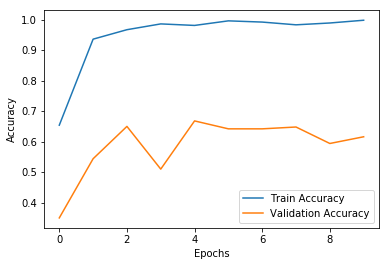

In [14]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# MEL SPECTROGRAM CNN

In [15]:
train_X_ex = np.expand_dims(train_mel_spectrograms, -1)
test_X_ex = np.expand_dims(test_mel_spectrograms, -1)
print 'train X shape:', train_X_ex.shape
print 'test X shape:', test_X_ex.shape

train X shape: (1000, 128, 40, 1)
test X shape: (500, 128, 40, 1)


In [16]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(10, activation='softmax')(m)

model = Model(input=ip, output=op)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 40, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 37, 64)       1088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 9, 64)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 9, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 17856)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                571424    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total para

/Users/dima/.virtualenvs/hs/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
          train_y,
          epochs=10,
          batch_size=32,
          verbose=1,
          validation_data=(test_X_ex, test_y))

Train on 1000 samples, validate on 500 samples
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 2.1539 - acc: 0.4050 - val_loss: 2.2378 - val_acc: 0.2060
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 1.0881 - acc: 0.6450 - val_loss: 2.2974 - val_acc: 0.1640
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7304 - acc: 0.8020 - val_loss: 2.4219 - val_acc: 0.1600
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5459 - acc: 0.8530 - val_loss: 2.4777 - val_acc: 0.1580
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3867 - acc: 0.9170 - val_loss: 2.6358 - val_acc: 0.1660
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3840 - acc: 0.9110 - val_loss: 2.5003 - val_acc: 0.1800
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3243 - acc: 0.9190 - val_loss: 2.5728 - val_acc: 0.2120
Epoch 8/10
1000

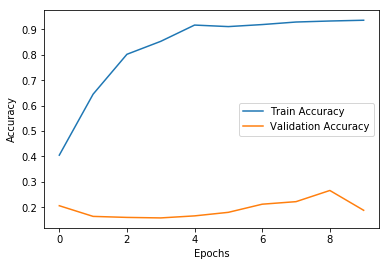

In [18]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# MFCC CNN

In [ ]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print 'train X shape:', train_X_ex.shape
print 'test X shape:', test_X_ex.shape

In [ ]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
# m = Conv2D(128, kernel_size=(2, 2), activation='relu')(ip)
# m = MaxPooling2D(pool_size=(2, 2))(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(10, activation='softmax')(m)

model = Model(input=ip, output=op)

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
          train_y,
          epochs=100,
          batch_size=32,
          verbose=0,
          validation_data=(test_X_ex, test_y))

In [ ]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

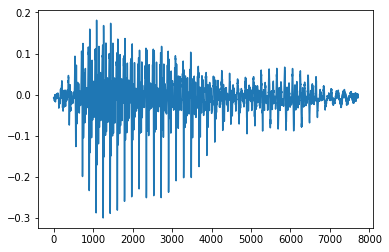

In [19]:
plt.plot(wav)

In [28]:
stft = np.abs(librosa.stft(wav))

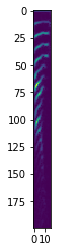

In [29]:
plt.imshow(np.abs(stft[:200, :]))

In [23]:
stft.shape

(1025, 16)

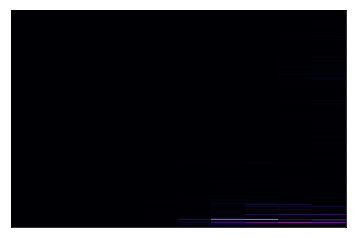

In [52]:

librosa.display.specshow(librosa.stft(wav),sr=sr)

Text(0.5,1,u'Linear-frequency power spectrogram')

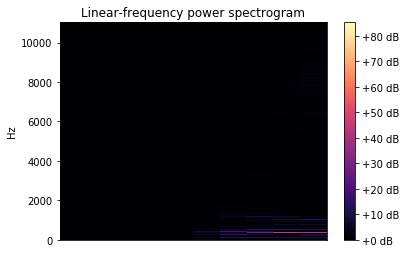

In [53]:
D = np.abs(librosa.stft(wav))
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

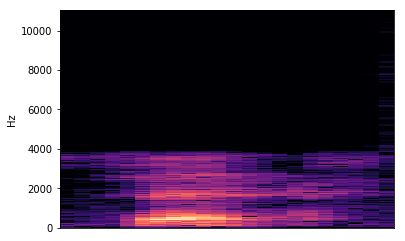

In [67]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')

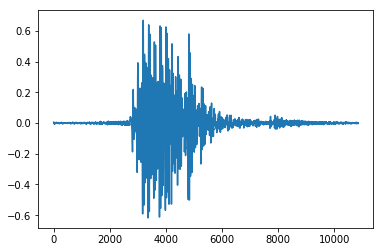

In [57]:
plt.plot(wav)

In [50]:
sr

22050